In [1]:
import pandas as pd
import json
import os
import glob
import datetime
import platform

In [2]:
# 指定数据目录
data_dir = './Data'

# 获取所有的jsonl文件
jsonl_files = glob.glob(os.path.join(data_dir, '*.jsonl'))

if not jsonl_files:
    print(f"在 {data_dir} 目录下未找到任何 .jsonl 文件")
    exit(1)

print(f"找到以下 .jsonl 文件：{[os.path.basename(f) for f in jsonl_files]}")

# 定义一个函数用于处理时间戳格式
def process_timestamp_column(df, column_name):
    if column_name in df.columns:
        print(f"处理{column_name}列，拆分为日期和时间...")
        
        # 创建新列存储日期和时间
        date_column = f"{column_name}_date"
        time_column = f"{column_name}_time"
        df[date_column] = ""
        df[time_column] = ""
        
        # 遍历每一行数据处理时间戳
        for idx, timestamp in enumerate(df[column_name]):
            if pd.notna(timestamp) and isinstance(timestamp, str):
                try:
                    # 尝试解析时间格式如 "Sun Apr 13 19:30:12 +0000 2025"
                    # 首先尝试标准格式
                    try:
                        dt = pd.to_datetime(timestamp, format="%a %b %d %H:%M:%S %z %Y")
                        df.at[idx, date_column] = dt.strftime('%Y-%m-%d')
                        df.at[idx, time_column] = dt.strftime('%H:%M:%S')
                    except:
                        # 如果标准解析失败，尝试自定义解析
                        parts = timestamp.split()
                        if len(parts) >= 6:
                            # 提取日期和时间部分
                            date_str = f"{parts[0]} {parts[1]} {parts[2]} {parts[5]}"  # 周几 月份 日 年份
                            time_str = parts[3]  # 时:分:秒
                            
                            df.at[idx, date_column] = date_str
                            df.at[idx, time_column] = time_str
                except Exception as e:
                    print(f"无法解析{column_name}中的时间戳 '{timestamp}': {e}")
        
        # 调整列的顺序，将新列放在原时间戳列的后面
        cols = df.columns.tolist()
        timestamp_idx = cols.index(column_name)
        
        # 重新排列列的顺序
        new_cols = cols[:timestamp_idx+1] + [date_column, time_column] + [col for col in cols[timestamp_idx+1:] if col not in [date_column, time_column]]
        df = df[new_cols]
    else:
        print(f"注意: 未找到 '{column_name}' 列")
        
    return df

# 处理每个jsonl文件
for input_file in jsonl_files:
    # 生成输出文件名 - 将.jsonl替换为.xlsx
    base_filename = os.path.basename(input_file)
    filename_without_ext = os.path.splitext(base_filename)[0]
    output_file = os.path.join(data_dir, f"{filename_without_ext}.xlsx")
    
    print(f"\n处理文件: {base_filename}")
    
    # 读取JSONL文件并解析其结构
    all_tweets = []

    with open(input_file, 'r', encoding='utf-8') as f:
        for line_number, line in enumerate(f, 1):
            try:
                # 解析JSON
                json_obj = json.loads(line)
                
                # 检查是否有正确的数据结构
                if 'data' in json_obj and isinstance(json_obj['data'], list):
                    # 展平嵌套结构
                    for tweet in json_obj['data']:
                        # 创建一个平铺的字典来保存所有字段
                        flattened_tweet = {}
                        
                        # 添加基本字段
                        for key, value in tweet.items():
                            if key not in ['interaction', 'author']:
                                flattened_tweet[key] = value
                        
                        # 添加interaction字段
                        if 'interaction' in tweet and tweet['interaction'] is not None:
                            for int_key, int_value in tweet['interaction'].items():
                                flattened_tweet[f'interaction_{int_key}'] = int_value
                        
                        # 添加author字段
                        if 'author' in tweet and tweet['author'] is not None:
                            for auth_key, auth_value in tweet['author'].items():
                                flattened_tweet[f'author_{auth_key}'] = auth_value
                        
                        all_tweets.append(flattened_tweet)
                else:
                    print(f"警告: 行 {line_number} 的数据结构与预期不符: {json_obj.keys()}")
                    
            except json.JSONDecodeError as e:
                print(f"解析JSON时出错 (行 {line_number}): {e}")
                continue

    # 检查是否有数据
    if not all_tweets:
        print(f"警告: 在 {base_filename} 中没有成功解析任何推文数据")
        continue

    # 转换为DataFrame
    df = pd.DataFrame(all_tweets)

    # 处理时间戳列
    # 处理author_registed_timestamp列
    df = process_timestamp_column(df, 'author_registed_timestamp')
    
    # 处理publish_time列
    df = process_timestamp_column(df, 'publish_time')

    # 打印数据框的基本信息
    print(f"数据框包含 {len(df)} 行和 {len(df.columns)} 列")
    
    # 处理可能的Excel文件大小限制
    if len(df.columns) > 16384:  # Excel的列数限制
        print(f"警告: 列数 ({len(df.columns)}) 超过Excel限制 (16384)，将只保存前16384列")
        df = df.iloc[:, :16384]
    
    # 保存为xlsx文件
    df.to_excel(output_file, index=False)
    print(f"文件已成功转换并保存至: {output_file}")

print("\n所有文件处理完成！")

找到以下 .jsonl 文件：['twitter_keywords_zo tech.jsonl']

处理文件: twitter_keywords_zo tech.jsonl
处理author_registed_timestamp列，拆分为日期和时间...
处理publish_time列，拆分为日期和时间...
数据框包含 898 行和 37 列
文件已成功转换并保存至: ./Data\twitter_keywords_zo tech.xlsx

所有文件处理完成！


最常见的语言统计:
lang
en     882
tl       5
in       4
iw       3
de       1
ja       1
und      1
ro       1
Name: count, dtype: int64

共有 8 种不同的语言

语言分布百分比:
lang
en     98.22%
tl      0.56%
in      0.45%
iw      0.33%
de      0.11%
ja      0.11%
und     0.11%
ro      0.11%
Name: count, dtype: object


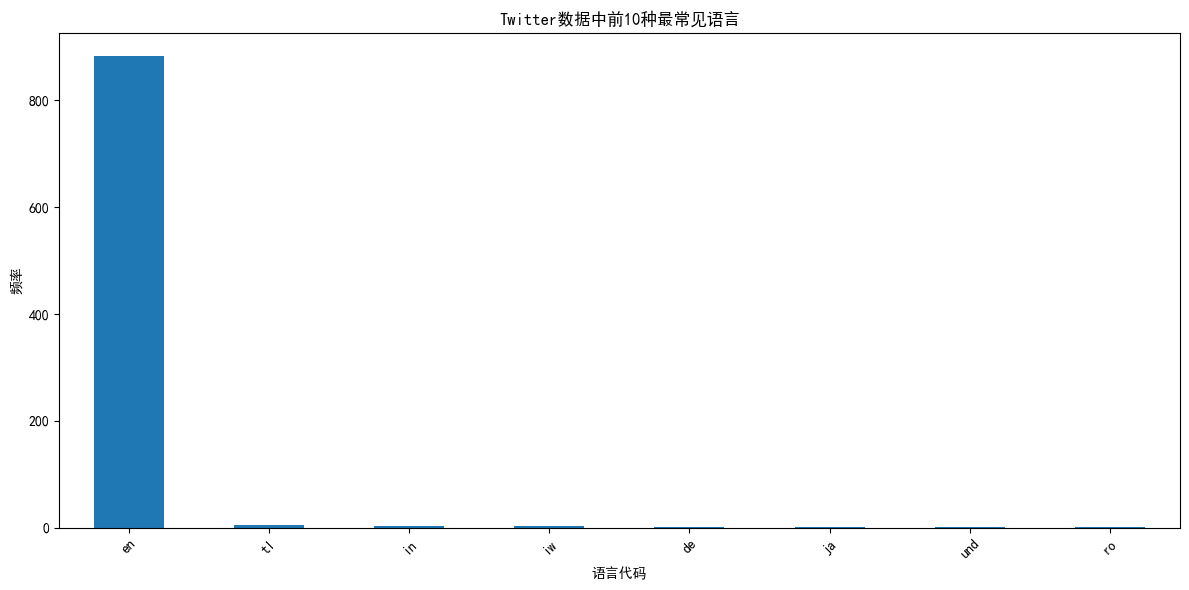

In [3]:
# 统计lang列的内容和频率
lang_counts = df['lang'].value_counts()

# 查看前20个最常见的语言
print("最常见的语言统计:")
print(lang_counts.head(20))

# 查看语言总数
print(f"\n共有 {len(lang_counts)} 种不同的语言")

# 计算百分比
lang_percentage = lang_counts / len(df) * 100

# 显示百分比
print("\n语言分布百分比:")
print(lang_percentage.head(20).round(2).astype(str) + '%')

# 可视化语言分布
import matplotlib.pyplot as plt
# 根据操作系统设置合适的中文字体
system = platform.system()
if system == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'PingFang HK', 'Apple Color Emoji']
elif system == 'Windows':
    plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun']
else:  # Linux或其他
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei', 'WenQuanYi Zen Hei']

# 正常显示负号
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(12, 6))
lang_counts.head(10).plot(kind='bar')
plt.title('Twitter数据中前10种最常见语言')
plt.xlabel('语言代码')
plt.ylabel('频率')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
